In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.ReMasFrame import ReMasFrame

In [3]:
nasa_df = ReMasFrame()

In [89]:
# Choose an idx --> a landslide (or filter the geodataframe :D)

idx_test = 11031
nasa_df

,location_description,landslide_size,event_date,landslide_category,landslide_trigger,fatality_count,injury_count,longitude,latitude,geometry
0,"Sigou Village, Loufan County, Shanxi Province",large,2008-08-01,landslide,rain,11.0,NaN,107.450000,32.562500,POINT (107.45 32.5625)
1,"Lake Oswego, Oregon",small,2009-01-02,mudslide,downpour,0.0,NaN,-122.663000,45.420000,POINT (-122.663 45.42)
2,"San Ramon district, 195 miles northeast of the...",large,2007-01-19,landslide,downpour,10.0,NaN,-75.358700,-11.129500,POINT (-75.3587 -11.1295)
3,Dailekh district,medium,2009-07-31,landslide,monsoon,1.0,NaN,81.708000,28.837800,POINT (81.708 28.8378)
5,"Paguite, Abuyog, Leyte",medium,2012-02-16,landslide,downpour,0.0,NaN,124.966800,10.700400,POINT (124.9668 10.7004)
...,...,...,...,...,...,...,...,...,...,...
11025,"Marine View Dr, Tacoma, Washington, 98422",small,2016-11-01,landslide,rain,0.0,0.0,-122.409942,47.290915,POINT (-122.409942 47.29091500000001)
11026,"Tamisk, North Ossetia, Russia",small,2017-06-21,mudslide,rain,0.0,0.0,44.211414,42.954914,POINT (44.21141438 42.95491382)
11027,"509 S Sunset Terrace, Above Highway 97, Harris...",small,2017-03-23,mudslide,rain,0.0,0.0,-116.777680,47.449165,POINT (-116.7776802 47.44916502)
11028,"Banaran, Ponorogo, Jawa Timur, Indonesia",medium,2017-04-01,landslide,rain,27.0,0.0,111.679944,-7.853409,POINT (111.6799444 -7.853409423)


In [4]:
# changes Point to Polygon
nasa_df_polygon = nasa_df.create_box(5000000)

In [96]:
# Returns products that we use as a dict
products = nasa_df.get_products()

# Choose CHIRPS Daily Precip
chirps = products['weather']['chirps']

# Returns start and end date of a 4 day interval
start_date, end_date = nasa_df.date_interval(nasa_df.event_date[idx_test], delta=10)

In [97]:
scenes, ctx = ReMasFrame.search_scenes(
    nasa_df['geometry'][idx_test].buffer(2).envelope, 
    chirps['id'], 
    start_date=start_date, 
    end_date=end_date, 
    limit=10
)
scenes[-1]

Scene "chirps:daily:v1:chirps-v2.0.2017.04.28_60_50"
  * Product: "chirps:daily:v1"
  * CRS: "+proj=longlat +datum=WGS84 +no_defs "
  * Date: Fri Apr 28 00:00:00 2017
  * Bands:
    * alpha: 0.05 degrees, Byte, [0.0, 1.0]
    * daily_precipitation: 0.05 degrees, Float32, [0.0, 500.0]

In [106]:
scene = scenes[4]
arr = scene.ndarray("daily_precipitation", ctx)
arr

masked_array(
  data=[[[0.0, 0.0, 0.0, ..., 0.0, 0.0, --],
         [0.0, 0.0, 0.0, ..., 0.0, 0.0, --],
         [0.0, 0.0, 0.0, ..., 0.0, 0.0, --],
         ...,
         [0.0, 0.0, 0.0, ..., 0.0, 0.0, --],
         [0.0, 0.0, 0.0, ..., 0.0, 0.0, --],
         [--, --, --, ..., --, --, --]]],
  mask=[[[False, False, False, ..., False, False,  True],
         [False, False, False, ..., False, False,  True],
         [False, False, False, ..., False, False,  True],
         ...,
         [False, False, False, ..., False, False,  True],
         [False, False, False, ..., False, False,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],
  fill_value=1e+20,
  dtype=float32)

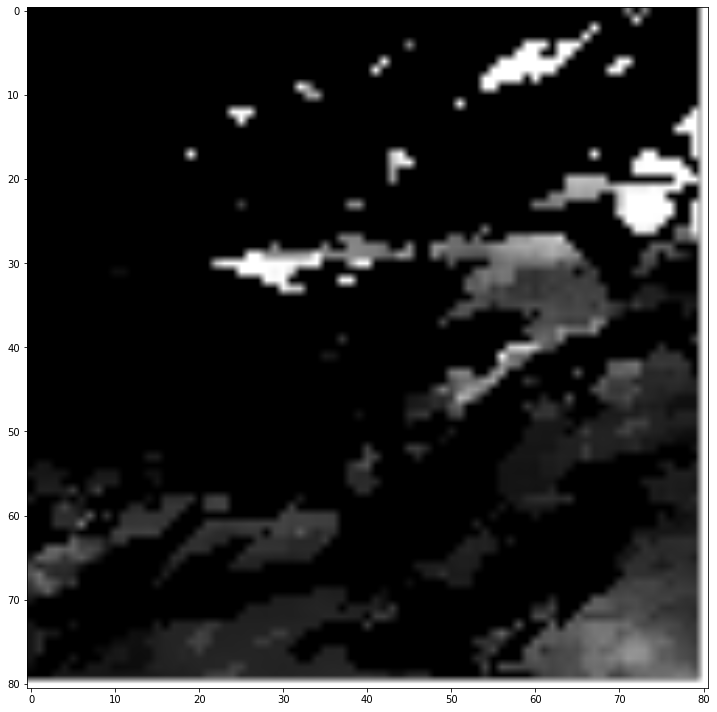

In [105]:
import descarteslabs as dl
dl.scenes.display(arr)